# Ансамбли

### OzonMasters, "Машинное обучение 1"

В этом ноутбуке вам предлагается реализовать алгоритмы бустинга и бэггинга.

In [1]:
import numpy as np
import numpy.testing as npt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.datasets import make_classification

## 1. Сэмплирование случайных объектов и признаков

Во многих ансамблевых алгоритмах используется прием, заключающийся в обучении на случайной подвыборке объектов или на случайном подмножестве признаков.

Так что для начала реализуем класс, который будет упрощать семплирование различных подмассивов данных

В классе `ObjectSampler` надо реализовать метод `sample`, который возвращает случайную подвыборку объектов обучения и ответы для них

In [2]:
class BaseSampler:
    def __init__(self, max_samples=1.0, bootstrap=False):
        """
        Parameters
        ----------
        bootstrap : Boolean
            if True then use bootstrap sampling
        max_samples : float in [0;1]
            proportion of sampled examples
        """
        self.bootstrap = bootstrap
        self.max_samples = max_samples
    
    def sample(self, x):
        raise NotImplementedError

class ObjectSampler(BaseSampler):
    def __init__(self, axis=0, max_samples=1.0, bootstrap=True):
        """
        Parameters
        ----------
        axis : int
            which axis use to sample
        """
        self.axis = axis
        super().__init__(max_samples=max_samples, bootstrap=bootstrap)
    
    def sample(self, x, y):
        """
        Parameters
        ----------
        x : numpy ndarray of shape (n_objects, n_features)
        y : numpy ndarray of shape (n_objects,)
        
        Returns
        -------
        x_sampled, y_sampled : numpy ndarrays of shape (n_samples, n_features) and (n_samples,)
            n_samples = x_sampled.shape[0] * self.max_samples
        """
        idx = np.random.choice(x.shape[0], int(x.shape[0] * self.max_samples), self.bootstrap)
        x_sampled = x[idx]
        y_sampled = y[idx]
        return x_sampled, y_sampled

В классе `FeaturesSampler` надо реализовать метод `sample`, который возвращает случайную подвыборку индексов признаков, по которым будет производится обучение

In [3]:
class FeaturesSampler(BaseSampler):
    def __init__(self, axis=1, max_samples=1.0, bootstrap=False):
        self.axis = axis
        super().__init__(max_samples=max_samples, bootstrap=bootstrap)
        
    def sample(self, x):
        """
        Parameters
        ----------
        x : numpy ndarray of shape (n_objects, n_features)
        
        Returns
        -------
        indices : numpy ndarrays of shape (n_features_sampled)
        """
        indices = np.random.choice(x.shape[1], int(x.shape[1] * self.max_samples), self.bootstrap)
        return indices

In [4]:
some_X = np.array([[0, 1, 2], [0.3, 1, 3], [0.5, 1, 3], [1, 2, 1]])
some_y = np.array([1, 5, 3, 1])

object_sampler = ObjectSampler(max_samples=0.7)
feature_sampler = FeaturesSampler(max_samples=0.7)

assert object_sampler.sample(some_X, some_y)[0].shape == (int(0.7*some_X.shape[0]), some_X.shape[1])
assert object_sampler.sample(some_X, some_y)[1].shape == (int(0.7*some_y.shape[0]),)

sample_X, sample_y = object_sampler.sample(some_X, some_y)

for sub_x, sub_y in zip(sample_X, sample_y):
    assert sub_x.tolist() in some_X.tolist()
    assert sub_y in sample_y

assert feature_sampler.sample(some_X).shape == (int(0.7*some_X.shape[1]),)

## 2. Бэггинг

Суть бэггинга заключается в обучении нескольких 'слабых' базовых моделей и объединении их в одну модель, обладающую бОльшей обобщающей способностью. Каждая базовая модель обучается на случайно выбранном подмножестве объектов и на случайно выбранном подмножестве признаков для этих объектов.

Ниже вам предлагается реализовать несколько методов класса `Bagger`:
* `fit` - обучение базовых моделей
* `predict_proba` - вычисление вероятностей ответов
* `predict` - вычисление ответов

In [5]:
class Bagger:
    def __init__(
        self, base_estimator,
        object_sampler, feature_sampler,
        n_estimators=10, **params
    ):
        """
        n_estimators : int
            number of base estimators
        base_estimator : class
            class for base_estimator with fit(), predict() and predict_proba() methods
        feature_sampler : instance of FeaturesSampler
        object_sampler : instance of ObjectSampler
        estimators : list
            list for containing base_estimator instances
        indices : list
            list for containing feature indices for each estimator
        params : kwargs
            params for base_estimator initialization
        """
        self.n_estimators = n_estimators
        self.base_estimator = base_estimator
        self.feature_sampler = feature_sampler
        self.object_sampler = object_sampler
        self.estimators = []
        self.indices = []
        self.params = params
    
    def fit(self, X, y):
        """
        for i in range(self.n_estimators):
            1) select random indices of features for current estimator
            2) select random objects and answers for train
            3) fit base_estimator (don't forget to remain only selected features)
            4) save base_estimator (self.estimators) and feature indices (self.indices)
        
        NOTE that self.base_estimator is class and you should init it with
        self.base_estimator(**self.params) before fitting
        """
        for i in range(self.n_estimators):
            features = self.feature_sampler.sample(X)
            X_samples, y_samples = self.object_sampler.sample(X, y)
            estimator = self.base_estimator(**self.params)
            estimator.fit(X_samples[:, features], y_samples)
            self.estimators.append(estimator)
            self.indices.append(features)
    
    def predict_proba(self, X):
        """
        Returns
        -------
        probas : numpy ndarrays of shape (n_objects, n_classes)
        
        Calculate mean value of all probas from base_estimators
        Don't forget, that each estimator has its own feature indices for prediction
        """
        probas = self.estimators[0].predict_proba(X[:, self.indices[0]])
        for i in range(1, self.n_estimators):
            probas += self.estimators[i].predict_proba(X[:, self.indices[i]])
        return np.array(probas) / self.n_estimators
    
    def predict(self, X):
        """
        Returns
        -------
        predictions : numpy ndarrays of shape (n_objects, )
        
        """
        predictions = np.argmax(self.predict_proba(X), axis=1)
        return predictions

Для проверки, обучим бэггинг над решающими деревьями (случайный лес)

In [6]:
class RandomForestClassifier(Bagger):
    def __init__(self, n_estimators=30, max_depth=None, min_samples_leaf=1):
        base_estimator = DecisionTreeClassifier
        objects_sampler = ObjectSampler(max_samples=0.9)
        features_sampler = FeaturesSampler(max_samples=0.8)
        
        super().__init__(
            base_estimator=base_estimator,
            object_sampler=object_sampler,
            feature_sampler=feature_sampler,
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf
        )

In [7]:
some_random_forest = RandomForestClassifier()

some_X, some_y = make_classification(n_samples=30, n_features=50,
                                     n_informative=50, n_redundant=0,
                                     random_state=0, shuffle=False)

some_random_forest.fit(some_X, some_y)
predictions = some_random_forest.predict(some_X)
assert isinstance(predictions, type(np.zeros(0)))
npt.assert_equal(predictions, some_y)

## 3. Градиентный бустинг

Бустинг последовательно обучает набор базовых моделей таким образом, что каждая следующая модель пытается исправить ошибки работы предыдущей модели. Логика того, как учитываются ошибки предыдущей модели может быть разной. В алгоритме градиентного бустинга каждая следующая модель обучается на "невязках" предыдущей модели, минимизируя итоговую функцию потерь. У каждого следующего алгоритма вычисляется вес $\alpha$, с которым он входит в ансамбль. Также есть параметр скорости обучения (learning rate), который не позволяет алгоритму переобучитсья. Вес $\alpha$ можно находить, используя одномерную оптимизацию. Можно записать процедуру обучения по шагам (будем рассматривать случай бинарной классификации c метками классов {0,1}, чтобы не усложнять жизнь):
1. Настройка базового алгоритма $b_0$.
    
    Алгоритм настраиваются на $y$ с помощью функции MSE.
    
    
2. Будем обозначать текущий небазовый алгоритм - $a$:
    
    $$a_i(x) = \sum_{j=0}^i \alpha_j b_j(x) $$
    
3. Настройка базового алгоритма $b_i$ (обычно это регрессионное дерево):
    
    $$b_i = \arg \min_b \sum_{j=1}^l (b(x_j) + \nabla L(a_{i-1}(x_j), y))^2,$$
    т.е. выход очередного базового алгоритма подстраивается под антиградиент функции потерь
    
4. Настройка веса базового алгоритма $\alpha_i$:
    
    $$\alpha_i = \min_{\alpha > 0} \sum_{j=1}^l L(a_{i-1} + \alpha b_i(x_j), y) $$
    
В случае классфикации будем использовать логистическую функцию потерь. Немного упростим ее:

$$L = -y\log\sigma(a) - (1-y)\log(1 - \sigma(a)) = -\log(1 - \sigma(a)) - y \log \frac{\sigma(a)}{1 - \sigma(a)},$$
где $\sigma$ - функция сигмоиды. Ответ после очередного базового алгоритма надо прогонять через сигмоиду, т.к. не гарантируется, что ответы будут лежать на [0,1] - в этом особенность базового алгоритма (который является регрессионным).

Преобразуем:
$$\log (1 - \sigma(a)) = \log \frac{1}{1 + \exp(a)} = -\log(1 + \exp(a)) $$

$$\log (\frac{\sigma(a)}{1 - \sigma(a)}) = \log(\exp(a)) = a $$
 
Таким образом:

$$L = -ya + \log(1 + \exp(a))$$

Тогда будем вычислять градиент как:
 
$$\nabla L = - y + \sigma(a)$$

Ниже вам предлагается реализовать стратегию обучения базовых классификаторов для `GradientBoostingClassifier`:
* `_fit_first_estimator` - обучение первой базовой модели
* `_fit_base_estimator` - обучение базовой модели
* `log_loss_gradient` - расчет градиента функции ошибки
* `log_loss` - расчет функции ошибки (для одномерной оптимизации)

А также метод `predict_proba` для класса `BoosterClassifier`.

In [8]:
from scipy.special import expit
from sklearn.tree import DecisionTreeRegressor
from scipy.optimize import shgo

In [44]:
class BoosterClassifier:
    last_indices = []
    last_estimators = []
    last_weights = []

    def __init__(
        self, base_estimator, feature_sampler,
        n_estimators=10, warm_start=False, lr=.5, **params
    ):
        """
        n_estimators : int
            number of base estimators
        base_estimator : class
            class for base_estimator with fit(), predict() and predict_proba() methods
        feature_sampler : instance of FeaturesSampler
        estimators : list
            list for containing base_estimator instances
        indices : list
            list for containing feature indices for each estimator
        weights : list
            list for containing estimators weights
        lr : float
            learning rate for estimators
        params : kwargs
            kwargs for base_estimator init
        """
        self.n_estimators = n_estimators
        self.base_estimator = base_estimator
        self.feature_sampler = feature_sampler
        self.estimators = []
        self.indices = []
        self.lr = lr
        self.params = params
        self.weights = []
        self.warm_start = warm_start

    @classmethod
    def update_all(cls, indices, estimators, weights):
        cls.last_indices = indices
        cls.last_estimators = estimators
        cls.last_weights = weights
    
    def _fit_first_estimator(self, X, y):
        raise NotImplementedError
        
    def _fit_base_estimator(self, X, y):
        raise NotImplementedError
    
    def fit(self, X, y):
        """
        X : X : numpy ndarray of shape (n_objects, n_features)
        y : numpy ndarray of shape (n_objects, )
        -------
        iteratively fits base models
        """
        if self.warm_start is False or len(self.last_indices) == 0:
            self._fit_first_estimator(X, y)
            predictions_base = self.estimators[-1].predict(np.take(X, self.indices[-1], axis=1)) * self.weights[0]
            for i in range(self.n_estimators - 1):
                predictions_base = self._fit_base_estimator(X, y, predictions_base)
        else:
            self.estimators = self.last_estimators
            self.indices = self.last_indices
            self.weights = self.last_weights
            predictions_base = self.estimators[0].predict(X[:, self.indices[0]]) * self.weights[0]
            k = len(self.estimators)
            for i in range(1, k):
                predictions_base += self.estimators[i].predict(X[:, self.indices[i]]) * self.weights[i]
            for i in range(k, self.n_estimators):
                predictions_base = self._fit_base_estimator(X, y, predictions_base)
        self.update_all(self.indices, self.estimators, self.weights)

    def predict_proba(self, X):
        """
        Returns
        -------
        probas : numpy ndarray of shape (n_objects, )
            predictions for one class
        -------
        1) get predictions by first model (self.estimators[0])
        2) for each estimator in self.estimators[1:] (and its indicies and weights):
            update predictions
        3) turn into probability distribution with sigmoid function
        """
        probas = self.estimators[0].predict(X[:, self.indices[0]]) * self.weights[0]
        for i in range(1, self.n_estimators):
            probas += self.estimators[i].predict(X[:, self.indices[i]]) * self.weights[i]
        probas = expit(probas)
        return probas
    
    def predict(self, X):
        probas = self.predict_proba(X)
        return (probas > 0.5).astype(int)

In [45]:
class GradientBoostingClassifier(BoosterClassifier):
    def __init__(self, n_estimators=30, lr=0.5, max_depth=2, min_samples_leaf=1, warm_start=False):
        """
        n_estimators : int
            number of base estimators
        base_estimator : class
            class for base_estimator with fit(), predict() and predict_proba() methods
        feature_sampler : instance of FeaturesSampler
        estimators : list
            list for containing base_estimator instances
        indices : list
            list for containing feature indices for each estimator
        lr : float
            learning rate for estimators
        params : kwargs
            kwargs for base_estimator init
        """
        
        base_estimator = DecisionTreeRegressor
        feature_sampler = FeaturesSampler(max_samples=0.8)
        super().__init__(
            base_estimator=base_estimator,
            feature_sampler=feature_sampler,
            n_estimators=n_estimators,
            lr=lr,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            warm_start=warm_start
        )

    def log_loss_gradient(self, y, pred):
        """
        Returns
        -------
        gradient : numpy ndarrays of shape (n_objects, )
        """
        gradient = y - expit(pred)
        return gradient
    
    def log_loss(self, y, pred):
        """
        Returns
        -------
        loss : log loss for inputs
        """
        loss = np.logaddexp(0, pred) - (y * pred)
        return loss
    
    def function_to_optimize(self, y, prediction_pred, prediction_est, alpha):
        return self.log_loss(y, prediction_pred + alpha * prediction_est).sum()
    
    def _fit_first_estimator(self, X, y):
        """
        1) select random indices of features for first estimator
        2) fit base_estimator (don't forget to remain only selected features)
        3) calculate optimal weight for estimator by optimization
        4) save base_estimator (self.estimators), feature indices (self.indices) and weight (self.weights)
        
        NOTE that self.base_estimator is class and you should init it with
        self.base_estimator(**self.params) before fitting
        """
        feature_indices = self.feature_sampler.sample(X)
        self.indices.append(feature_indices)
        first_estimator = self.base_estimator(**self.params).fit(X[:, feature_indices], y)
        self.estimators.append(first_estimator)
        prediction = first_estimator.predict(X[:, feature_indices])
        alpha = shgo(self.function_to_optimize,
                      [(0.0, 1.0)],
                      (y, 0, prediction)
                     ).x
        self.weights.append(alpha)
    
    def _fit_base_estimator(self, X, y, predictions_base):
        """
        X : numpy ndarrays of shape (n_objects, n_features)
        y : numpy ndarrays of shape (n_objects, )
        predictions_base : numpy ndarrays of shape (n_objects, n_classes)
            updated predictions from previous step
        -------
        Returns
        -------
        y_updated : numpy ndarrays of shape (n_objects, n_classes)
            updated predictions
        -------
        
        1) calculate gradient
        2) select random indices of features for current estimator
        3) fit estimator with predictions_base as target
        4) calculate optimal weight for estimator by optimization
        5) calculate y_updated
        6) save estimator, indicies and weights
        
        NOTE that self.base_estimator is class and you should init it with
        self.base_estimator(**self.params) before fitting
        """
        grad = self.log_loss_gradient(y, predictions_base)
        feature_indices = self.feature_sampler.sample(X)
        estimator = self.base_estimator(**self.params).fit(X[:, feature_indices], grad)
        prediction = estimator.predict(X[:, feature_indices])
        alpha = shgo(self.function_to_optimize,
                      [(0.0, 1.0)],
                      (y, predictions_base, prediction)
                     ).x
        y_updated = predictions_base + alpha * prediction
        self.indices.append(feature_indices)
        self.estimators.append(estimator)
        self.weights.append(alpha)
        return y_updated

In [41]:
some_gradient_classifier = GradientBoostingClassifier()
some_gradient_classifier.fit(some_X, some_y)
predictions = some_gradient_classifier.predict(some_X)
assert isinstance(predictions, type(np.zeros(0)))
npt.assert_equal(predictions, some_y)

## Эксперименты

Скачайте датасейт для экспериментов: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

Колонка с ответами - RainTommorow.

In [12]:
import pandas as pd

In [13]:
data = pd.read_csv('weatherAUS.csv')

In [14]:
data['Date'] = pd.to_datetime(data['Date'])

Выделите признаки год/месяц/день:

In [15]:
data['year'] = data['Date'].map(lambda x: x.year)
data['month'] = data['Date'].map(lambda x: x.month)
data['day'] = data['Date'].map(lambda x: x.day)

Посмотрим какие года есть в выборке:

In [16]:
data['year'].value_counts()

2016    17508
2014    17400
2015    17231
2009    16595
2010    16419
2013    16097
2011    15126
2012    15044
2017     8466
2008     2246
2007       61
Name: year, dtype: int64

Разделите выборку на три части (train, val и test) по временному принципу:
    
* train - 2007-2014
* val - 2015
* test - 2016-2017

In [17]:
data['year'] = data['year'].astype(int)

indexes = {
    'train': np.array(data.loc[data['year'] < 2015].index),
    'val': np.array(data.loc[data['year'] == 2015].index),
    'test': np.array(data.loc[data['year'] > 2015].index)
}

Здесь вы можете делать всевозможные преобразования признаков. 

Для того, чтобы получить качество, необходимое для преодоления бейзлайна, вам достаточно закодировать все категориальные признаки с помощью LabelEncoder, а также разумно обработать пропущенные значения.

In [18]:
data.drop(['Date'], axis=1, inplace=True)

Ваш таргет - RainTommorow. Удалите его из обучающих данных, также удалите признак RISK_MM.

In [19]:
target_data = data['RainTomorrow']
data.drop(['RainTomorrow', 'RISK_MM'], axis=1, inplace=True)

Для каждого из алгоритмов достигнутое качество должно быть: 
* RandomForest > 0.84
* GradientBoosting > 0.845

Для алгоритма AdaBoost, который предлагается реализовать в бонусной части, качество должно быть:
* AdaBoost > 0.83

Обучите каждый из алгоритмов до нужного качества, используйте валидационную выборку, чтобы подбирать гиперпараметры. Получите качество (accuracy) выше необходимого и на validation, и на test.

In [20]:
data

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,year,month,day
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,1007.7,1007.1,8.0,NaN,16.9,21.8,No,2008,12,1
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,1010.6,1007.8,NaN,NaN,17.2,24.3,No,2008,12,2
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,1007.6,1008.7,NaN,2.0,21.0,23.2,No,2008,12,3
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,1017.6,1012.8,NaN,NaN,18.1,26.5,No,2008,12,4
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,1010.8,1006.0,7.0,8.0,17.8,29.7,No,2008,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,Uluru,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,E,...,1024.7,1021.2,NaN,NaN,9.4,20.9,No,2017,6,20
142189,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,...,1024.6,1020.3,NaN,NaN,10.1,22.4,No,2017,6,21
142190,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,...,1023.5,1019.1,NaN,NaN,10.9,24.5,No,2017,6,22
142191,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,...,1021.0,1016.8,NaN,NaN,12.5,26.1,No,2017,6,23


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
Location         142193 non-null object
MinTemp          141556 non-null float64
MaxTemp          141871 non-null float64
Rainfall         140787 non-null float64
Evaporation      81350 non-null float64
Sunshine         74377 non-null float64
WindGustDir      132863 non-null object
WindGustSpeed    132923 non-null float64
WindDir9am       132180 non-null object
WindDir3pm       138415 non-null object
WindSpeed9am     140845 non-null float64
WindSpeed3pm     139563 non-null float64
Humidity9am      140419 non-null float64
Humidity3pm      138583 non-null float64
Pressure9am      128179 non-null float64
Pressure3pm      128212 non-null float64
Cloud9am         88536 non-null float64
Cloud3pm         85099 non-null float64
Temp9am          141289 non-null float64
Temp3pm          139467 non-null float64
RainToday        140787 non-null object
year             142193 non-null int6

In [22]:
numeral_features = data.select_dtypes('float64').columns
categorial_features = data.select_dtypes('object').columns

Заполним вещественные признаки средним

In [23]:
for column in numeral_features:
    data[column].fillna(data[column].mean(), inplace=True)

Категориальные модой

In [24]:
for column in categorial_features:
    data[column].fillna(data[column].mode()[0], inplace=True)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
Location         142193 non-null object
MinTemp          142193 non-null float64
MaxTemp          142193 non-null float64
Rainfall         142193 non-null float64
Evaporation      142193 non-null float64
Sunshine         142193 non-null float64
WindGustDir      142193 non-null object
WindGustSpeed    142193 non-null float64
WindDir9am       142193 non-null object
WindDir3pm       142193 non-null object
WindSpeed9am     142193 non-null float64
WindSpeed3pm     142193 non-null float64
Humidity9am      142193 non-null float64
Humidity3pm      142193 non-null float64
Pressure9am      142193 non-null float64
Pressure3pm      142193 non-null float64
Cloud9am         142193 non-null float64
Cloud3pm         142193 non-null float64
Temp9am          142193 non-null float64
Temp3pm          142193 non-null float64
RainToday        142193 non-null object
year             142193 non-null 

In [26]:
for column in categorial_features:
    categories = pd.get_dummies(data[column])
    categories.columns = [column + c for c in categories.columns]
    data = pd.concat([data, categories], axis=1, sort=False)

In [27]:
for column in categorial_features:
    data.drop([column], axis=1, inplace=True)

In [28]:
X = np.array(data)

In [29]:
X_train = X[indexes['train']]
X_val = X[indexes['val']]
X_test = X[indexes['test']]

In [30]:
y = np.array(target_data == 'Yes', dtype=float)

In [31]:
y_train = y[indexes['train']]
y_val = y[indexes['val']]
y_test = y[indexes['test']]

In [32]:
def accuracy(y_true, y_pred):
    assert y_true.shape[0] == y_pred.shape[0]
    return (y_true == y_pred).sum() / y_true.shape[0]

In [135]:
rf = RandomForestClassifier(n_estimators=100)

In [136]:
rf.fit(X_train, y_train)

In [140]:
accuracy(rf.predict(X_val), y_val)

0.8564796007196332

In [139]:
accuracy(rf.predict(X_test), y_test)

0.8443058443058443

Baseline пройден с первой попытки)

In [141]:
gb = GradientBoostingClassifier(n_estimators=10)

In [142]:
gb.fit(X_train, y_train)

In [143]:
accuracy(gb.predict(X_val), y_val)

0.8405199930358076

In [144]:
accuracy(gb.predict(X_test), y_test)

0.8295603295603295

Подбираем n_estimators

In [148]:
import matplotlib.pyplot as plt
%matplotlib inline

In [160]:
answer = {}
answer['n'] = []
answer['acc'] = []
n_esters = range(50, 1000, 50)

In [168]:
for k in n_esters:
    gb = GradientBoostingClassifier(n_estimators=k, warm_start=True)
    gb.fit(X_train, y_train)
    answer['n'].append(k)
    answer['acc'].append(accuracy(gb.predict(X_val), y_val))

No handles with labels found to put in legend.


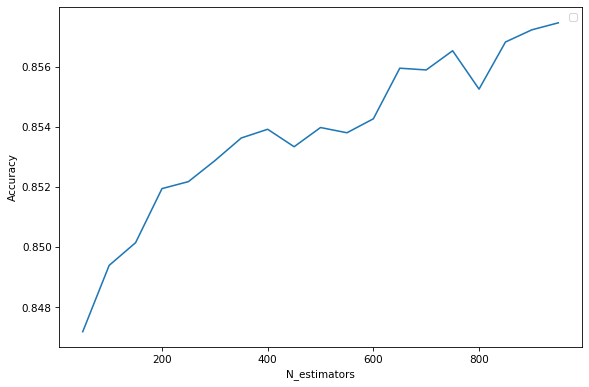

In [169]:
plt.figure(figsize=(9,6), dpi=75)
plt.plot(answer['n'], answer['acc'])
plt.xlabel('N_estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [170]:
accuracy(gb.predict(X_val), y_val)

0.8574661946491788

In [171]:
accuracy(gb.predict(X_test), y_test)

0.8479248479248479